In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
customers = pd.read_csv(os.path.join('data', 'Mall_Customers.csv'))

In [3]:
le = LabelEncoder()
customers['Gender'] = le.fit_transform(customers['Gender'])

In [4]:
for cl, lbl in zip(le.classes_, le.transform(le.classes_)):
    print(cl, ':', lbl)

Female : 0
Male : 1


In [5]:
X = torch.from_numpy(customers.values).float()

In [6]:
def cov(A):
    A -= A.mean(dim=0, keepdim=True)
    fact = 1.0 / (A.shape[0] - 1)
    cov = fact * A.T.mm(A)
    return cov


def pca(A, target_dim=2):
    cov_a = cov(A)

    U, S, V = torch.svd(cov_a)

    transform_mat = V[:, :target_dim]

    A_reduce = A.mm(transform_mat)
    return A_reduce, transform_mat

In [7]:
X_pca = pca(X)[0]

tensor([4.0145e+03, 6.9456e+02, 1.6729e+02, 2.5429e+01, 2.4544e-01])


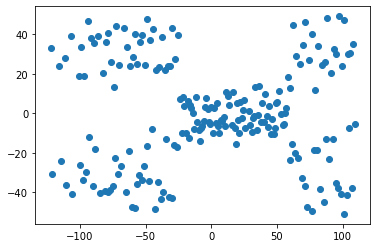

In [8]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])